# Generative Adversarial Network State Tomography Demo

WARNING: This particular model uses a complex deep learning model architecture built using the TensorFlow framework. It will not run unless you are using a GPU.

## Install libraries to runtime

If running in Google Colab, run the following setup cell once each time you open your project in order to install non-default package dependencies to the runtime. DO NOT RUN if you have already created a kernel with `qsttoolkit` as per the setup instructions in `README.md`.

In [1]:
!pip install numpy==1.26.4 pandas==2.2.2 scipy==1.13.1 matplotlib==3.9.2 seaborn==0.13.2 qutip==5.0.4 scikit-learn==1.5.1 tensorflow==2.10.0
!pip install -i https://test.pypi.org/simple/ qsttoolkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 44.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled

Looking in indexes: https://test.pypi.org/simple/


## Imports

All of QSTToolkit's features can be accessed by importing `qsttoolkit` and calling them directly. Most features sit within two main subpackages: `.data` and `.tomography`. In this example notebook, functions are called from their subpackage where relevant to show which features sit in each subpackage, and which lie in modules outside either:

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qutip as qt
import qsttoolkit as qst

## Data Preparation

We start by defining the dimensionality of our system as `Nc`, and the phase space grids for our measurement data - Husimi-Q function representations of the states in phase space. These grids are also defined to be `Nc` x `Nc` for simplicity:

In [3]:
Nc = 32
xgrid = np.linspace(-5, 5, Nc)
pgrid = np.linspace(-5, 5, Nc)

We first create test state density matrices of seven different varieties using the [QuTiP](https://qutip.org/docs/4.0.2/index.html) framework. The first three states can be produced directly using QuTiP functions, the other four are specific superpositions of Fock and coherent states and are produced using custom functions in `qsttoolkit.data`:

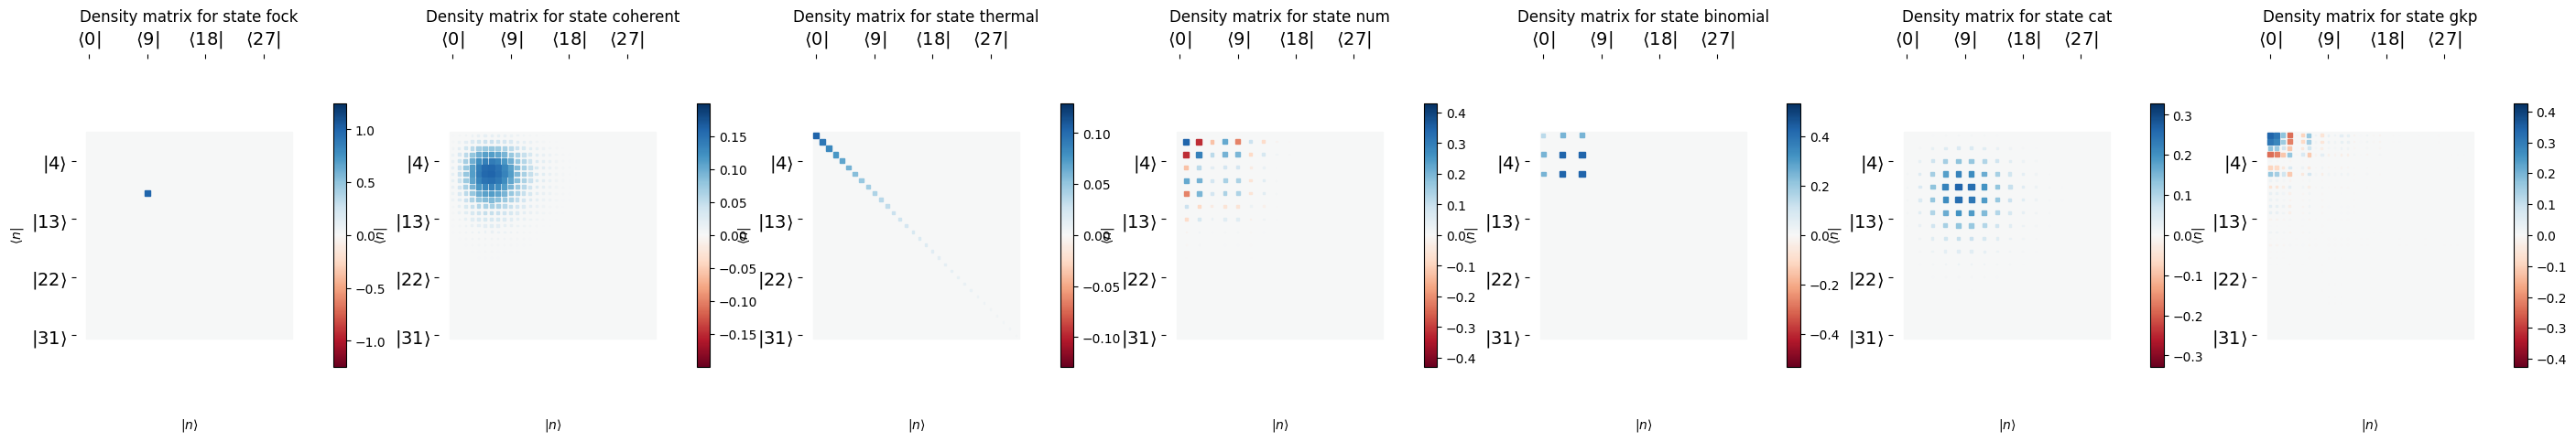

In [4]:
fock_test = qt.fock_dm(Nc, 9)
coherent_test = qt.coherent_dm(Nc, 2.5)
thermal_test = qt.thermal_dm(Nc, 9)
num_test = qt.ket2dm(qst.data.num_state('M2', Nc))
binomial_test = qt.ket2dm(qst.data.binomial_state(Nc, 2, 2, 1))
cat_test = qt.ket2dm(qst.data.cat_state(Nc, 3))
gkp_test = qt.ket2dm(qst.data.gkp_state(Nc, [-5, 5], [-5, 5], 0.5, 4.5))

fig, ax = plt.subplots(1, 7, figsize=(35, 5))
qst.plot_hinton(fock_test, ax=ax[0], label='fock')
qst.plot_hinton(coherent_test, ax=ax[1], label='coherent')
qst.plot_hinton(thermal_test, ax=ax[2], label='thermal')
qst.plot_hinton(num_test, ax=ax[3], label='num')
qst.plot_hinton(binomial_test, ax=ax[4], label='binomial')
qst.plot_hinton(cat_test, ax=ax[5], label='cat')
qst.plot_hinton(gkp_test, ax=ax[6], label='gkp')
plt.show()

We create the measurement operators for homodyne detection phase space Husimi-Q measurements of quantum states using `qsttoolkit.tomography.measurement_operators()`:

In [6]:
measurement_operators = qst.tomography.measurement_operators(Nc, 'Husimi-Q', xgrid=xgrid, pgrid=pgrid)

We then create, format and reshape the Husimi-Q measurement data for our test state. This data is defined as a single item list to calibrate with TensorFlow's input batch size definition. Redefine `test_state` below with the different states created above:

In [7]:
test_state = num_test.full()
measurement_data = [qst.expectation(test_state, measurement_operators).numpy().reshape(1, Nc**2)]

## Modelling

We create an instance of the `qsttoolkit.tomography.GANQuantumStateTomography` class, which handles the model architecture, compiling and training:

In [8]:
GAN_reconstructor = qst.tomography.GANQuantumStateTomography(dim = Nc, latent_dim = Nc)

Training the generator adversarially to learn to reconstruct the test density matrix from measurements using the `.reconstruct` method:

In [9]:
GAN_reconstructor.reconstruct(measurement_data = measurement_data,
                              measurement_operators = measurement_operators,
                              epochs=250,
                              verbose_interval=10,
                              num_progress_saves=5,
                              true_dm=num_test.full())

Epoch 0, Generator Loss: 0.667380690574646, Discriminator Loss: 0.7042583227157593
Epoch 10, Generator Loss: 0.713377058506012, Discriminator Loss: 0.6534741520881653
Epoch 20, Generator Loss: 0.752036452293396, Discriminator Loss: 0.601629376411438
Epoch 30, Generator Loss: 0.5923805236816406, Discriminator Loss: 0.6327633857727051
Epoch 40, Generator Loss: 0.43000537157058716, Discriminator Loss: 0.7321518063545227
Epoch 50, Generator Loss: 0.4927430748939514, Discriminator Loss: 0.7120919227600098
Epoch 60, Generator Loss: 0.647244393825531, Discriminator Loss: 0.6470456123352051
Epoch 70, Generator Loss: 0.6376845240592957, Discriminator Loss: 0.6659226417541504
Epoch 80, Generator Loss: 0.662029504776001, Discriminator Loss: 0.6516991853713989
Epoch 90, Generator Loss: 0.6818487644195557, Discriminator Loss: 0.6353442072868347
Epoch 100, Generator Loss: 0.6108576655387878, Discriminator Loss: 0.6822422742843628
Epoch 110, Generator Loss: 0.5750719308853149, Discriminator Loss: 0.7

## Analysis

Model statistics over training progress:

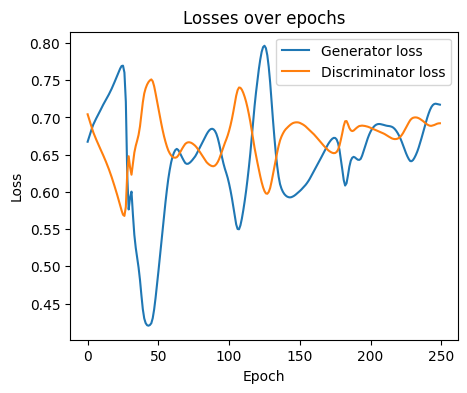

In [10]:
GAN_reconstructor.plot_losses()

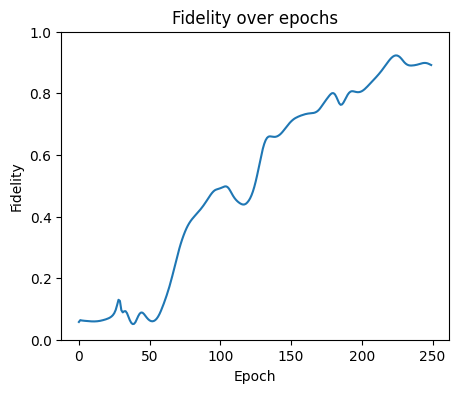

In [11]:
GAN_reconstructor.plot_fidelities()

Comparison of the true and reconstructed states:

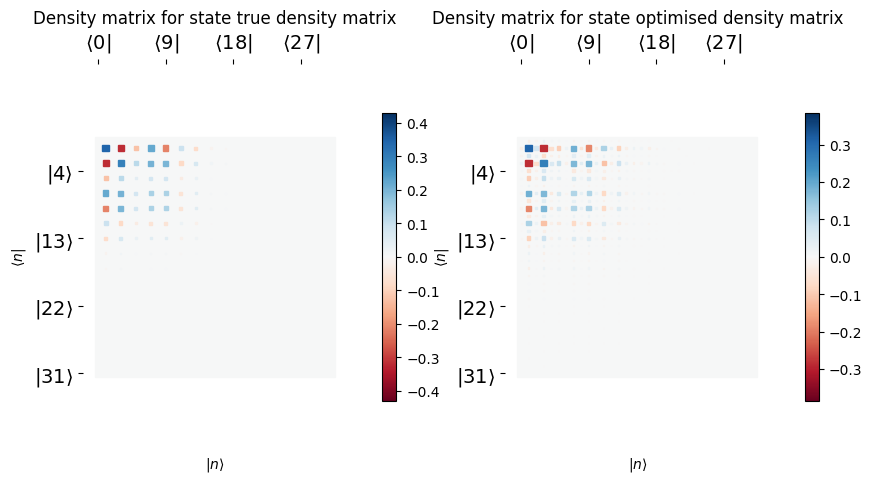

In [12]:
GAN_reconstructor.plot_comparison_hintons(num_test.full())

GANs train to find a balance between the performance of the generator and discriminator models. The plot below displays the fidelity between the true and reconstructed states for each point in the generator/discriminator loss space over the training:

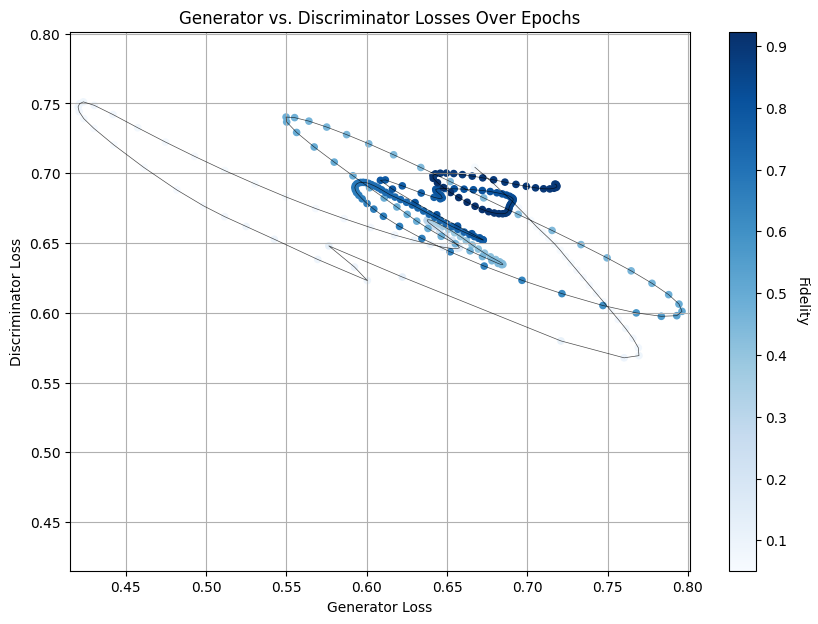

In [13]:
GAN_reconstructor.plot_loss_space()

`GANQuantumStateTomography.generator` and `GANQuantumStateTomography.discriminator` can be treated as `tensorflow.keras.Model` objects, for example:

In [14]:
GAN_reconstructor.generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_vector_input (InputLay  [(None, 1024)]           0         
 er)                                                             
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 2)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 64)       2112      
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0     

In [15]:
GAN_reconstructor.discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_vector_input (InputLay  [(None, 1024)]           0         
 er)                                                             
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                           